# Overfit and Underfit

You have already learned about overfitting and underfitting in the context of machine learning algorithms. Unfortunately, these topics are also important when it comes to training an artificial neural network.

You may have observed in previous notebooks that the accuracy(/mae) of your model on the validation set reaches a peak(/minimum) after training for a number of epochs and then stagnates or, worse, starts to decrease(/increase). This is a clear sign that the model is overfitting the training data. 

Artificial neural networks tend to overfit the data. It is possible to achieve extremely high accuracy (or low mae) on your training data if you just train your model long enough. However, this is not desirable because these models do not generalize well and will perform poorly on a test set or new data.

Underfitting is another problem. If your model is not powerful enough, it is over-regularized, or it has not been trained long enough, it may perform poorly on the training and test set because it has not been able to learn the relevant features from the data.

The best way to prevent your model from overfitting is using a dataset for training that covers the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

However, sometimes you will need to use different regularization techniques to counteract the overfitting of the data. In this notebook we will explore some common techniques that can help you with this task.

#### At the end of the notebooks you should: 

* know different strategies to tackle overfitting
* know how to apply L1 or L2 regularization
* know what `dropout layers` are and how to use them

## Setup

Before getting started, import the necessary packages:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers


import pathlib
import shutil
import tempfile

print(tf.__version__)


2.15.0


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
# Define seeds etc.
RSEED = 42
tf.keras.backend.set_floatx('float64')
plt.rcParams['figure.figsize'] = (15, 10)

## The Boston Housing data set

We will use the boston housing data set in this notebook. You can find it in the data folder in this repo.

In [4]:
# Load data from data folder
df = pd.read_csv('data/boston.csv')
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7


In [5]:
# Shape of dataframe
df.shape

(506, 13)

In [6]:
# Check for missings
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64

In [7]:
# Define target and remove from df 
target = df.pop("MEDV")

In [8]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=RSEED)

In [9]:
# Scale numerical values
col_scale = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT']

scaler = StandardScaler()
X_train[col_scale] = scaler.fit_transform(X_train[col_scale])
X_test[col_scale] = scaler.transform(X_test[col_scale])

In [10]:
# Convert to np array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Model Complexity

One way to counteract under- or overfitting without using any regularization technique is to adapt the model complexity. The larger your neural network is the easier it is to overfit the data. 

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.
To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until the validation loss gets worse.

In this notebook we will train three different models with varying complexity on the Boston housing data set and compare their performance. The results will be stored in a dictionary and the following plotting functions will help us to visualize the performance.
We will also define the optimizer we want to use as well as a [learning rate decay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay). Many models train better with a gradually decreasing learning rate during training.
The `optimizers.schedule` helps us to reduce the learning rate over time:

In [11]:
# Define dictionary to store results
training_history = {}

# Define number of epochs and learning rate decay
N_TRAIN = len(X_train)
EPOCHS = 2000
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.01,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)


# Define optimizer used for modelling
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, name='Adam')

In [12]:
# Plotting function for MSE
def plot_metric(history):
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [13]:
# Plotting function for loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

### Small model

We'll start with a rather small model with two hidden layers and 32 units.

The following function contains our models architecture (the number of layers and units) as well as information about the optimizer, loss and metric we use. 

In [14]:
# Define model architecture in function
def get_compiled_small_model():
    small_model = tf.keras.Sequential([
      tf.keras.layers.Dense(32,kernel_initializer = 'uniform', activation='relu', input_dim = 12),
      tf.keras.layers.Dense(32,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
    ])

    small_model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mse'])
    return small_model

In [15]:
# Instantiate small model and print model summary
with tf.device('/cpu:0'):
    small_model = get_compiled_small_model()
    print(small_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1505 (11.76 KB)
Trainable params: 1505 (11.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [16]:
with tf.device('/cpu:0'):
    training_history['small'] = small_model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        verbose=0,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS)

We can visualize the progress that our model makes during the training process by plotting the MSE on the training and validation set against the number of epochs.

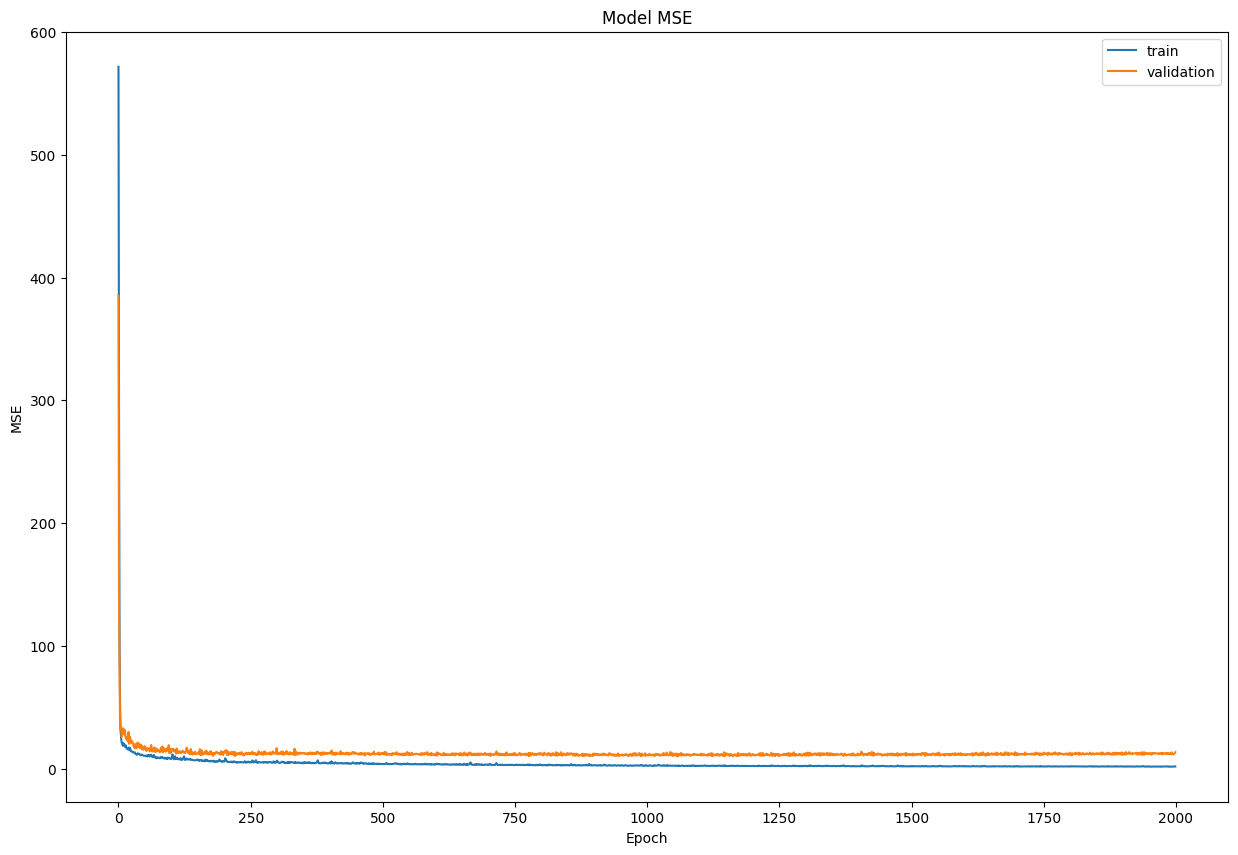

In [17]:
# plot MSE history 
plot_metric(training_history['small'])

The same works for the loss. We can also visualize how the loss improved during training:

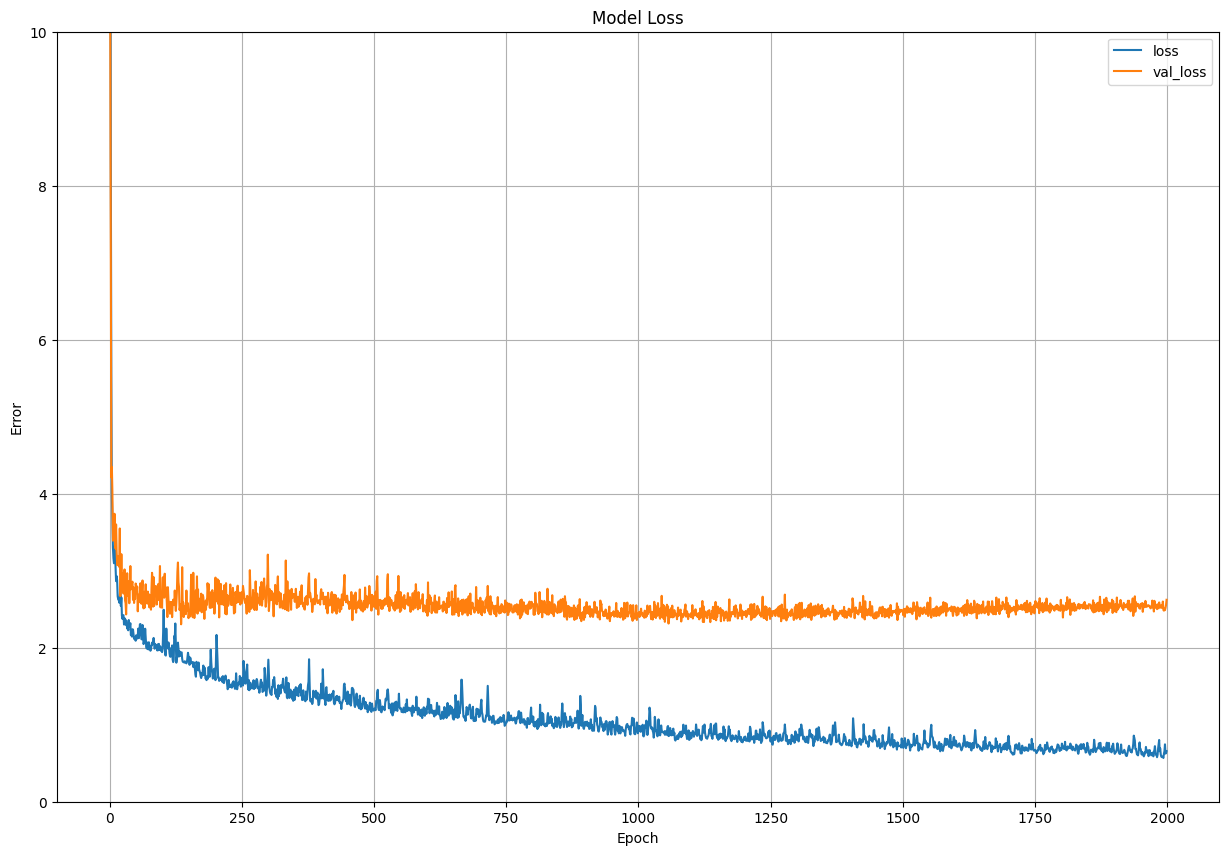

In [18]:
# Plot loss history
plot_loss(training_history['small'])

If we want to evaluate the performance of our model on unseen data we can use the hold out test set we put aside at the beginning of the modelinng part. Its possible to evaluate the model performance using `.evaluate` or make predictions via `.predict` and calculate the MSE using sklearn's implemenatation `mean_squared_error`. Both should return the same value.

In [19]:
# Evaluate the small model on test set using .evaluate
loss, mse = small_model.evaluate(X_test, y_test, verbose=2)
print(f'Model MSE: {mse}')
print('--------'*5)

# Predict values for test set
y_pred = small_model.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))

4/4 - 0s - loss: 2.2355 - mse: 10.9235 - 424ms/epoch - 106ms/step
Model MSE: 10.923477769903469
----------------------------------------
4/4 [==============================] - 1s 2ms/step
MSE: 10.923477769903473


### Save checkpoints during training

Training a articfical neural network can sometimes take a lot of time. Luckily, the `tf.keras.callbacks.ModelCheckpoin` callback allows you to continually save the model both during and at the end of training.
So you can use a trained model without having to retrain it, or pick-up training where you left off in case the training process was interrupted.

#### Checkpoint callback usage
We will create a `tf.keras.callbacks.ModelCheckpoint` callback that saves weights only during training.

In [20]:
# Define path where checkpoints should be stored
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0) # Set verbose != 0 if you want output during training 

### Medium Model

We can increase the complexity of our model by adding another hidden layer and increasing the number of units to 64. 
The steps for compiling the model and training it remain the same but this time we will add the prior defined callback when we fit our model. 

In [21]:
# Function for medium model architecture 
def get_compiled_medium_model():
    medium_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64,kernel_initializer = 'uniform', activation='relu', input_dim = 12),
      tf.keras.layers.Dense(64,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(64,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
    ])

    medium_model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mse'])
    return medium_model

In [22]:
# Summary of medium sized model
with tf.device('/cpu:0'):
    medium_model = get_compiled_medium_model()
    print(medium_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                832       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9217 (72.01 KB)
Trainable params: 9217 (72.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Train the medium model with the new callback
with tf.device('/cpu:0'):
    training_history['medium'] = medium_model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        verbose=0, 
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS,
                        callbacks=[cp_callback])  # Pass callback to training

In [ ]:
# Visualize MSE with medium model
plot_metric(training_history['medium'])

In [ ]:
# Visualize loss with medium model
plot_loss(training_history['medium'])

In [ ]:
# Evaluate the medium model on test set using .evaluate
loss, mse = medium_model.evaluate(X_test, y_test, verbose=2)
print(f'Model MSE: {mse}')

### Large Model

Let's further increase the architecture of our model. We'll add another layer and increase the amount of units to 512.

In [ ]:
# Function for large model architecture 
def get_compiled_large_model():
    large_model = tf.keras.Sequential([
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', input_dim = 12),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
    ])

    large_model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mse'])
    return large_model

In [ ]:
# Summary of large sized model
with tf.device('/cpu:0'):
    large_model = get_compiled_large_model()
    print(large_model.summary())

In [ ]:
# Train the model with the new callback
with tf.device('/cpu:0'):
    training_history['large'] = large_model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        verbose=0,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS)

In [ ]:
# Visualize MSE with large model
plot_metric(training_history['large'])

In [ ]:
# Visualize loss with large model
plot_loss(training_history['large'])

In [ ]:
# Evaluate the large model on test set using .evaluate
loss, mse = large_model.evaluate(X_test, y_test, verbose=2)
print(f'Model MSE: {mse}')

## Strategies to prevent overfitting

### Regularization 

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

In the next section we will try out one form of **regularization**. Hopefully, you all are familiar with L1 and L2 regularization as we talked about it several times during the bootcamp. Nevertheless, let's refresh the general concepts before we move on: 

We can apply regularization techniques in order generate a simpler model to prevent overfitting. A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". It is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights - one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization to our large model from above:

In [ ]:
# Large model with additional L2 regularization
def get_compiled_l2_model():
    l2_model = tf.keras.Sequential([
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01),
                            input_dim = 12),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
    ])

    l2_model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mse'])
    return l2_model

`l2(0.01)` means that every coefficient in the weight matrix of the layer will add `0.01 * weight_coefficient_value**2` to the total **loss** of the network.

In [ ]:
# Summary of model architecture
with tf.device('/cpu:0'):
    l2_model = get_compiled_l2_model()
    print(l2_model.summary())

In [ ]:
# Train regularized model
with tf.device('/cpu:0'):
    training_history['l2'] = l2_model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        verbose=0,
                        steps_per_epoch=STEPS_PER_EPOCH,                                      
                        epochs=EPOCHS)

In [ ]:
# Visualize MSE with l2 model
plot_metric(training_history['l2'])

In [ ]:
# Visualize loss with l2 model
plot_loss(training_history['l2'])

In [ ]:
# Evaluate the regularized model
loss, mse = l2_model.evaluate(X_test, y_test, verbose=2)
print(f'Model MSE: {mse}')

As you can see, the "L2" regularized model is now much more competitive with the the "Medium" model. This "L2" model is also much more resistant to overfitting than the "Big" model it was based on despite having the same number of parameters.

### Dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add a Dropout layer after each dense layer in our network to see how they influence our models performance:

In [ ]:
# Large model with additional dropout layer
def get_compiled_dropout_model():
    dropout_model = tf.keras.Sequential([
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', input_dim = 12),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
    ])

    dropout_model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mse'])
    return dropout_model

In [ ]:
# Summary of model architecture
with tf.device('/cpu:0'):
    dropout_model = get_compiled_dropout_model()
    print(dropout_model.summary())

In [ ]:
# Train dropout model
with tf.device('/cpu:0'):
    training_history['dropout'] = dropout_model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        verbose=0,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS)

In [ ]:
# Visualize MSE with dropout model
plot_metric(training_history['dropout'])

In [ ]:
# Visualize loss with dropout model
plot_loss(training_history['dropout'])

In [ ]:
# Evaluate the dropout model
loss, mse = dropout_model.evaluate(X_test, y_test, verbose=2)
print(f'Model MSE: {mse}')

### Combine L2 and Dropout

It's also possible and common to combine differnt regularisation techniques in one model. 

In [ ]:
# Large model with additional dropout layer and L2 regularization
def get_compiled_l2_dropout_model():
    l2_dropout_model = tf.keras.Sequential([
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01),
                            input_dim = 12),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(512,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
    ])

    l2_dropout_model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mse'])
    return l2_dropout_model

In [ ]:
# Summary of model architecture
with tf.device('/cpu:0'):
    l2_dropout_model = get_compiled_l2_dropout_model()
    print(l2_dropout_model.summary())

In [ ]:
# Train the model
with tf.device('/cpu:0'):
    training_history['l2_dropout'] = l2_dropout_model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        verbose=0,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS)

In [ ]:
# Visualize MSE with dropout and l2 model
plot_metric(training_history['l2_dropout'])

In [ ]:
# Visualize loss with dropout and l2 model
plot_loss(training_history['l2_dropout'])

In [ ]:
# Evaluate the dropout-l2 model
loss, mse = l2_dropout_model.evaluate(X_test, y_test, verbose=2)
print(f'Model MSE: {mse}')

## Visualize results

We can use the `tfdocs.plots.HistoryPlotter` to plot and compare all the results of our models. 

In [ ]:
# Instantiate HistoryPlotter
plotter = tfdocs.plots.HistoryPlotter(metric = 'mse', smoothing_std=10)

In [ ]:
# Plot results of all models
plotter.plot(training_history)
plt.xlim([5, max(plt.xlim())])
plt.ylim([0, 50])
plt.xlabel('Epochs')
plt.title('Comparison of all models')
plt.legend(loc='upper right');

From the plot above we can see that the large model without any regularization and the same model with L2 regularization achieved the best perfomance on the train as well as validation set. 
Their performance on the test set is also better than the one of the other models we trained.

In [ ]:
print('Large Model loss and MSE:')
loss_large, mse_large = large_model.evaluate(X_test, y_test, verbose=2)
print('----'*10)
print('L2 Model loss and MSE:')
loss_l2, mse_l2 = l2_model.evaluate(X_test, y_test, verbose=2)

## Summary

As we can see from our models above, the Boston housing data set is not the best choice when it comes to demonstrate overfitting. All the models are only starting to overfit the data (more or less) after training for quite some time. We can easly restrict the number of epochs to generate proper results. Nevertheless, in this notebook you have learnt some important techniques to regularize your models. 

Let's recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.

## Saving our model

Call `model.save` to save a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code. (Custom objects (e.g. subclassed models or layers) require special attention when saving and loading.) Since the optimizer-state is recovered, you can resume training from exactly where you left off.

An entire model can be saved in two different file formats (`SavedModel` and `HDF5`). The TensorFlow `SavedModel` format is the default file format in TF2.x. However, models can be saved in `HDF5` format, too.

Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (SavedModel, HDF5)

Let's have a look on how you can save your model useing `SaveModel`.

### SavedModel format

The `SavedModel` format is another way to serialize models. Models saved in this format can be restored using `tf.keras.models.load_mode` and are compatible with TensorFlow Serving.

In the next cell we will save our small model in this format.

In [ ]:
# Save the entire small model as a SavedModel.
!mkdir -p saved_model
large_model.save('saved_model/my_large_model')

If you want to see how you can load the model in order to make predictions, have a look at the next notebook...